In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [4]:
%matplotlib inline
import numpy as np
import scipy as sc
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_style('whitegrid')
from datetime import datetime
from pcia_analysis import *
import scipy.stats as ss
from statsmodels.graphics.api import qqplot
from pprint import pprint
gas_demand = RAW_DATA['motor_gasoline_supplied']
us_population = RAW_DATA['population_us_mo_nsa_middle']
gas_demand = resample_dataseries(gas_demand, 'M', 'Value')
us_population = resample_dataseries(us_population, 'M', 'VALUE') / 1000.0 # So that boxcox works

# Gasoline Demand Per Capita:
gas_per_capita = (gas_demand/us_population).dropna(axis=0)

# Now we simply smooth the seasonality out.
gas_per_capita_sa_m = pa.SeasonalAdjustment(gas_per_capita)
print(gas_per_capita)
gas_per_capita_sa = gas_per_capita_sa_m.fit()

1959-01-31    617.849139
1959-02-28    537.803049
1959-03-31    641.597740
1959-04-30    674.339813
1959-05-31    689.061412
1959-06-30    724.612046
1959-07-31    733.742269
1959-08-31    713.244947
1959-09-30    697.555624
1959-10-31    644.473279
1959-11-30    621.647698
1959-12-31    656.954466
1960-01-31    589.302030
1960-02-29    574.457547
1960-03-31    636.616305
1960-04-30    688.238070
1960-05-31    687.467075
1960-06-30    739.823215
1960-07-31    716.367639
1960-08-31    732.566872
1960-09-30    678.277457
1960-10-31    671.731017
1960-11-30    662.124352
1960-12-31    658.287816
1961-01-31    601.138133
1961-02-28    553.000312
1961-03-31    667.599950
1961-04-30    623.292646
1961-05-31    723.789784
1961-06-30    729.980607
                 ...    
2013-08-31    892.032445
2013-09-30    845.806954
2013-10-31    873.128242
2013-11-30    842.412017
2013-12-31    845.255805
2014-01-31    806.189196
2014-02-28    760.635507
2014-03-31    846.532819
2014-04-30    843.076769


In [3]:
print(gas_demand)

Date
1945-01-31     40310.0
1945-02-28     38690.0
1945-03-31     42511.0
1945-04-30     45351.0
1945-05-31     47515.0
1945-06-30     47091.0
1945-07-31     51409.0
1945-08-31     56974.0
1945-09-30     54943.0
1945-10-31     53309.0
1945-11-30     52352.0
1945-12-31     48888.0
1946-01-31     50317.0
1946-02-28     46921.0
1946-03-31     55802.0
1946-04-30     61276.0
1946-05-31     65797.0
1946-06-30     62277.0
1946-07-31     67784.0
1946-08-31     65470.0
1946-09-30     61273.0
1946-10-31     65339.0
1946-11-30     60381.0
1946-12-31     59875.0
1947-01-31     56053.0
1947-02-28     49634.0
1947-03-31     58897.0
1947-04-30     62315.0
1947-05-31     69219.0
1947-06-30     69498.0
                ...   
2013-08-31    282851.0
2013-09-30    268394.0
2013-10-31    277261.0
2013-11-30    267684.0
2013-12-31    268755.0
2014-01-31    256477.0
2014-02-28    242108.0
2014-03-31    269597.0
2014-04-30    268654.0
2014-05-31    279707.0
2014-06-30    271181.0
2014-07-31    286709.0
2014-0

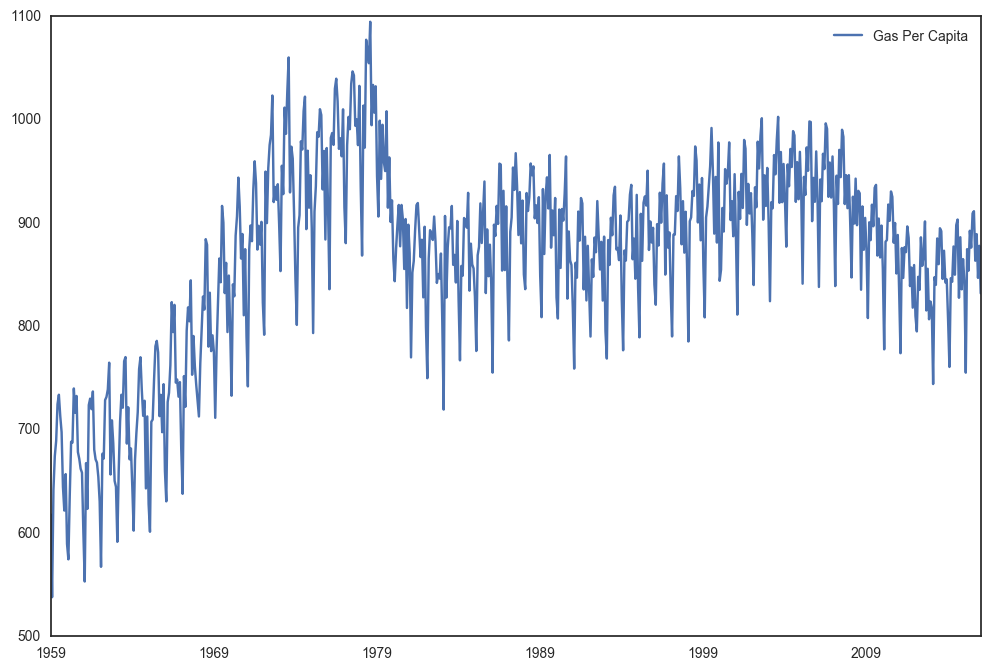

In [3]:
plt_label_holder = gas_per_capita.plot(figsize=(12,8), label='Gas Per Capita')
plt.legend()

In [4]:
# Box-cox transformation
reference_series_boxcox = ss.boxcox(gas_per_capita)
reference_series = pd.Series(reference_series_boxcox[0], index=gas_per_capita.index)

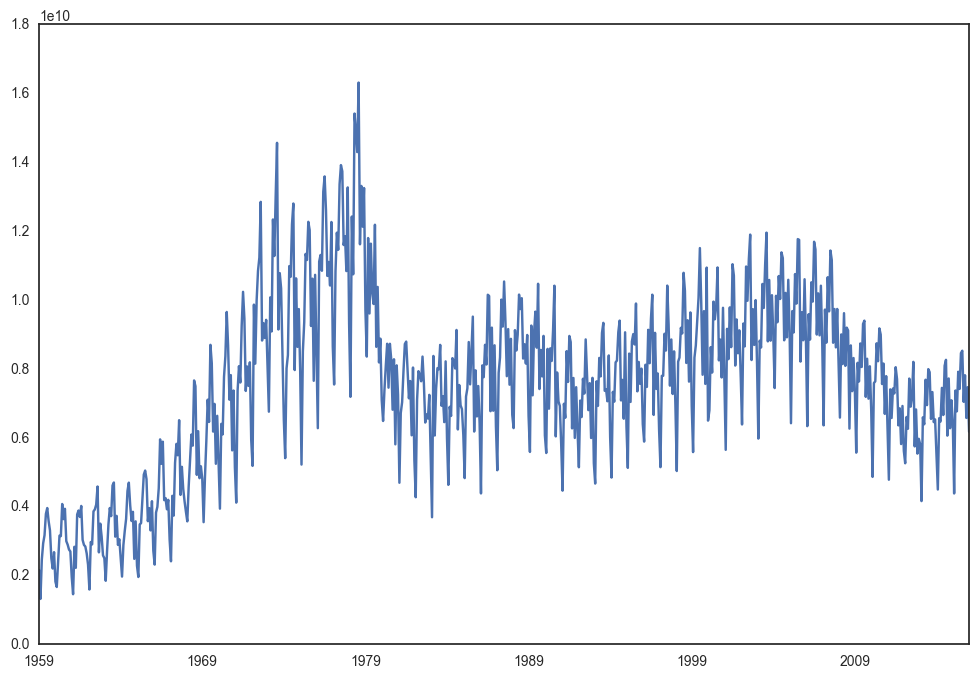

In [5]:
reference_series.plot(figsize=(12,8))
lambda_boxcox_reference = reference_series_boxcox[1]

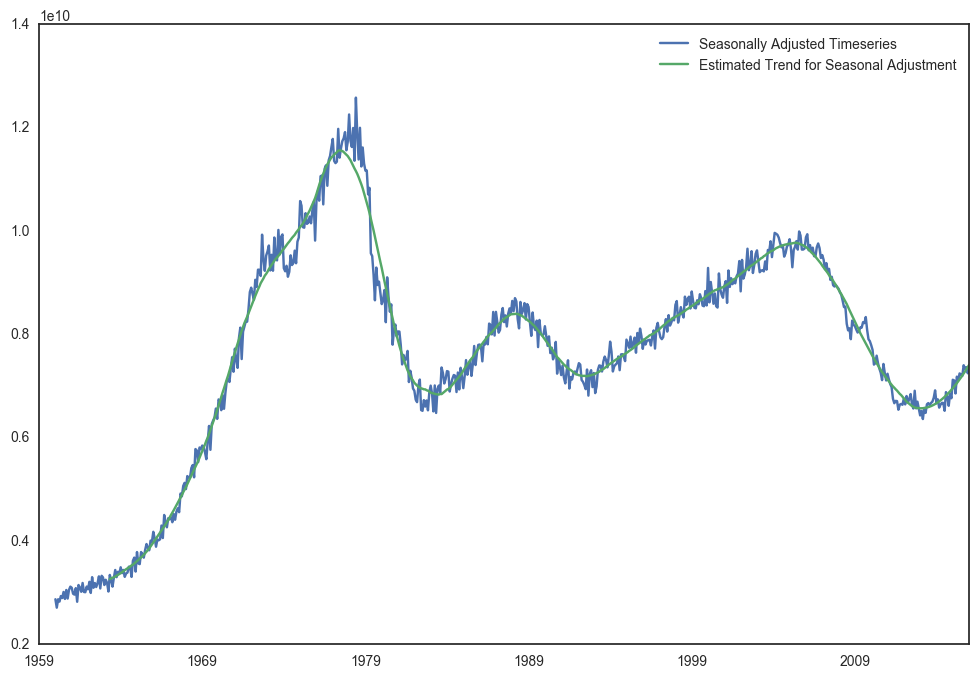

In [6]:
# Now let's deseason/detrend
reference_series_sa_m = pa.SeasonalAdjustment(reference_series)
reference_series_sa = reference_series_sa_m.fit()
# Plot seasonally adjusted series
seasonally_adjusted_ts = reference_series_sa['sa_timeseries']
seasonally_adjusted_ts.plot(figsize=(12,8), label='Seasonally Adjusted Timeseries')
estimated_trend = reference_series_sa['trend']
estimated_trend.plot(figsize=(12,8), label='Estimated Trend for Seasonal Adjustment')
plt.legend()
# Note this isn't stationary...

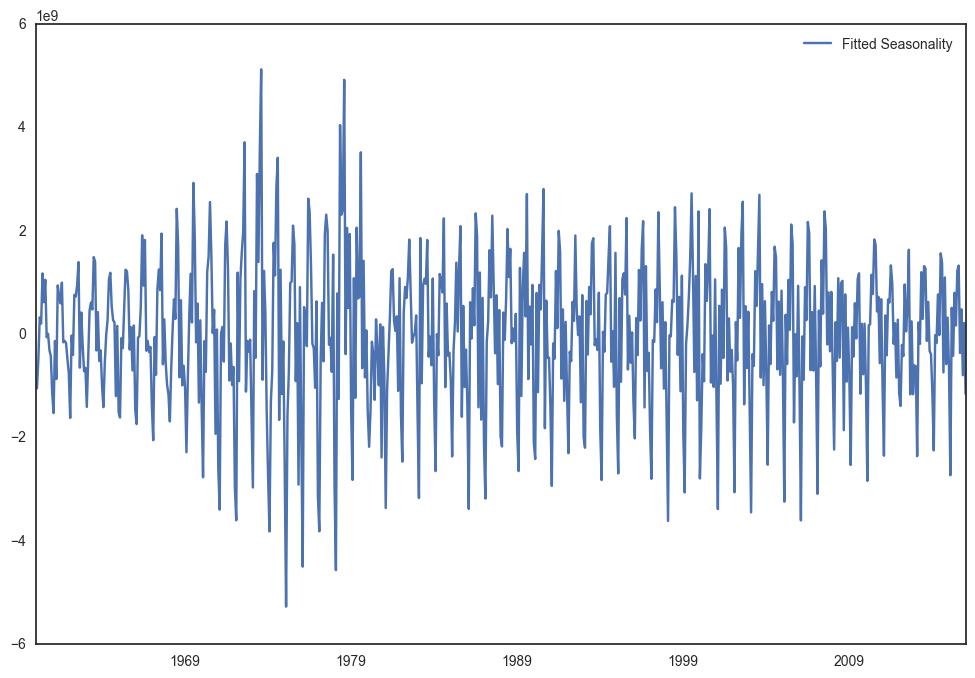

In [7]:
seasonal_pattern = reference_series_sa['seasonality_and_errors']['fitted_seasonality']
seasonal_pattern.plot(figsize=(12,8), label='Fitted Seasonality')
plt.legend()

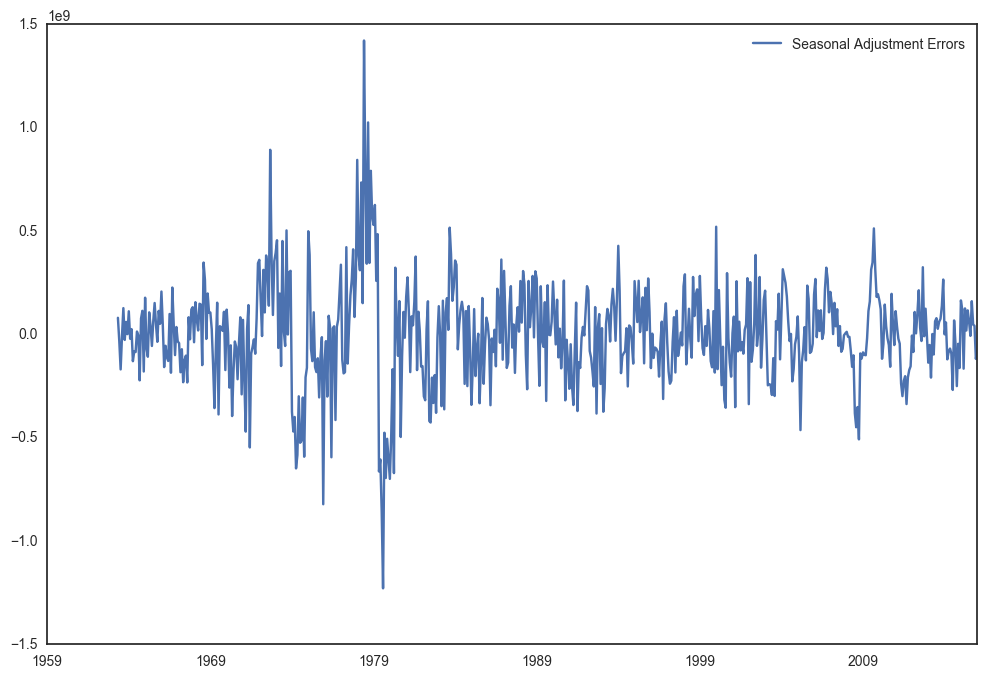

In [8]:
# Analyzing the errors from trend...
seasonal_adjustment_errors = seasonally_adjusted_ts - estimated_trend
seasonal_adjustment_errors.plot(figsize=(12,8), label='Seasonal Adjustment Errors')
plt.legend()

# Looks stationary (but clearly autoregressive)
seasonal_adjustment_errors = seasonal_adjustment_errors.dropna()

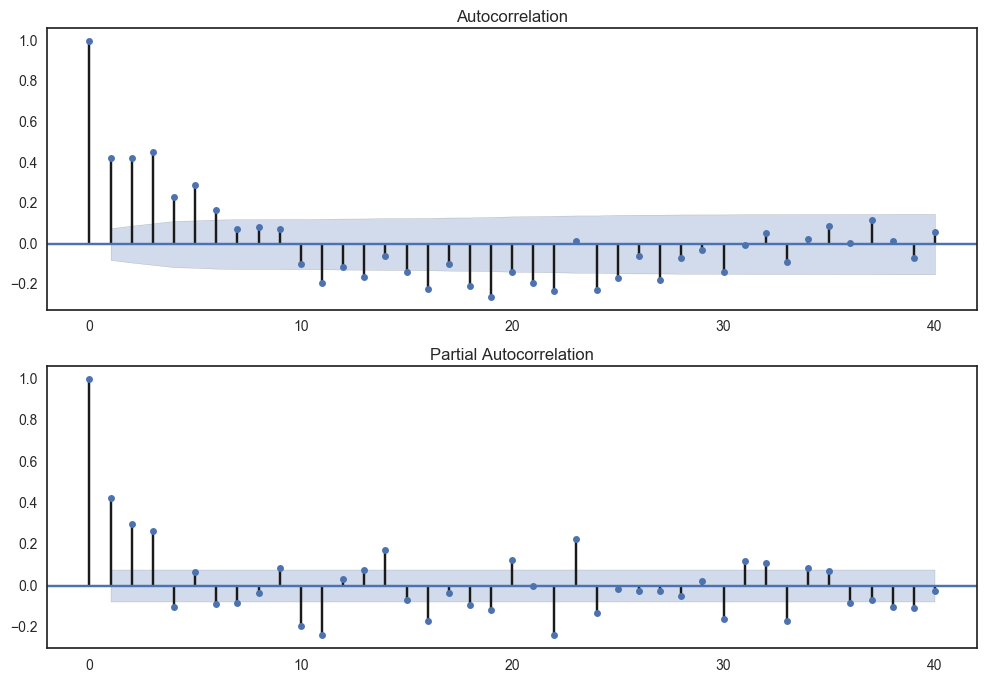

In [9]:
# Let's do some ACF/PACF Stuff to 1st differences.
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(seasonal_adjustment_errors.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(seasonal_adjustment_errors, lags=40, ax=ax2)

# Could be an ARMA(3,3) model. Let's look at it after fitting.

In [10]:
# No Bueno on AR(2) model. Let's try sarimax
endog = reference_series
# Now the exogenous variables are the ones we've already tested before

def new_parse(series_name):
    _, series, _ = parse_series(series_name)
    series_orig = series['original'].copy()
    series_boxcox = ss.boxcox(series['sa_timeseries'])
    series = pd.Series(series_boxcox[0], index=series['sa_timeseries'].index)
    return series, series_boxcox, series_orig

# # Note this isn't stationary...

In [11]:
# The exogenous series will be my LEI
# New variables for LEI

lei_variables = [
    'two_ten_spread',
    'housing_units_started_single_family',
    'ism_mfg_pmi',
    'umich_consumer_sentiment',
    'manufacturers_new_orders_durable_goods',
    'nyse_composite_index'
]

lei_reference_series = 'us_ip_final_products'
lei = pa.LeadingIndicatorManager(lei_reference_series, lei_variables)
lei_fit = lei.fit()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     958.4
Date:                Fri, 16 Dec 2016   Prob (F-statistic):          6.91e-138
Time:                        15:59:17   Log-Likelihood:                -355.06
No. Observations:                 781   AIC:                             712.1
Df Residuals:                     780   BIC:                             716.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1732      0.038     30.959      0.0

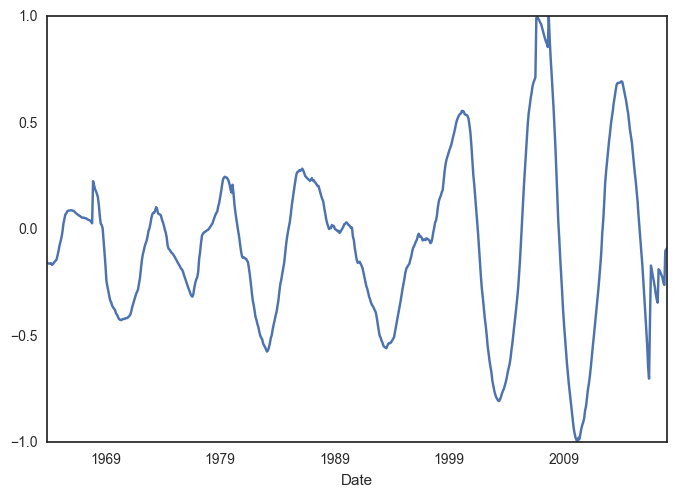

In [12]:
lei_fit['ols_lei'].plot()
print(lei_fit['ols_result'].summary())
for series in lei._indicator_lead_data.keys():
    print("Series {0} with lead {1}".format(series, lei._indicator_lead_data[series]['lead']))


In [13]:
#
# I'll do something different now..
#

# Plan: Fit ARIMAX model to trend, fit SARIMAX model to seasonality, and then predict the easier observation
# Equation from them. Then put it together.

endog_trend = estimated_trend
endog_sa_errors = seasonal_adjustment_errors
endog_cycle = seasonal_pattern

exog = pd.DataFrame({
        'lei': lei_fit['rlm_lei'].copy()
}).fillna(method='ffill').dropna(axis=0)

exog = exog.ix['1970':'2016-01']

endog_trend = endog_trend.ix['1970':'2016-01']
endog_cycle = endog_cycle.ix['1970':'2016-01']
endog_sa_errors = endog_sa_errors.ix['1970':'2016-01']

# Now let/s create the models but no fitting.
trend_sarimax = sm.tsa.statespace.SARIMAX(endog_trend, trend='t', exog=exog, order=(1,1,0), seasonal_order=(2,1,1,12),
                                          enforce_stationarity=False, enforce_invertibility=False)
endog_sa_errors_sarimax = sm.tsa.statespace.SARIMAX(endog_sa_errors, trend='n', exog=exog, order=(3,0,0), seasonal_order=(0,0,1,12))
cycle_sarimax = sm.tsa.statespace.SARIMAX(endog_cycle, trend='n', exog=exog, seasonal_order=(2,1,1,12))

In [14]:
trend_sarimax_fit = trend_sarimax.fit()
trend_sarimax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  553
Model:             SARIMAX(1, 1, 0)x(2, 1, 1, 12)   Log Likelihood               -8919.816
Date:                            Fri, 16 Dec 2016   AIC                          17853.631
Time:                                    15:59:32   BIC                          17883.839
Sample:                                01-31-1970   HQIC                         17865.433
                                     - 01-31-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        472.7902   1799.043      0.263      0.793   -3053.270    3998.850
lei         2.782e+07      0.023   1.19e+09      0.000    2.78e+07    2.78e+07
ar.L1          0.9750      0.012     83.642      0.000       0.952       0.998
ar.S.L12      -0.4515      0.051     -8.914      0.000      -0.551      -0.352
ar.S.L24      -0.3828      0.042     -9.190      0.000      -0.464      -0.301
ma.S.L12       0.0045      0.006      0.742      0.458      -0.007       0.016
sigma2      8.175e+13   3.25e-08   2.51e+21      0.000    8.17e+13    8.17e+13
===================================================================================
Ljung-Box (Q):                      587.21   Jarque-Bera (JB):                48.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.19e+37. Standard errors may be unstable.
"""

In [15]:
endog_sa_errors_sarimax_fit = endog_sa_errors_sarimax.fit()
endog_sa_errors_sarimax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  553
Model:             SARIMAX(3, 0, 0)x(0, 0, 1, 12)   Log Likelihood              -11384.575
Date:                            Fri, 16 Dec 2016   AIC                          22781.149
Time:                                    15:59:32   BIC                          22807.042
Sample:                                01-31-1970   HQIC                         22791.265
                                     - 01-31-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
lei         1.939e+07   3.23e-12      6e+18      0.000    1.94e+07    1.94e+07
ar.L1          0.1880      0.037      5.032      0.000       0.115       0.261
ar.L2          0.2345      0.035      6.785      0.000       0.167       0.302
ar.L3          0.2832      0.035      8.167      0.000       0.215       0.351
ma.S.L12      -0.1402      0.036     -3.914      0.000      -0.210      -0.070
sigma2      4.515e+16   2.45e-19   1.85e+35      0.000    4.52e+16    4.52e+16
===================================================================================
Ljung-Box (Q):                      232.90   Jarque-Bera (JB):               142.86
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.52e+50. Standard errors may be unstable.
"""

In [16]:
cycle_sarimax_fit = cycle_sarimax.fit()
cycle_sarimax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  553
Model:             SARIMAX(1, 0, 0)x(2, 1, 1, 12)   Log Likelihood              -11777.593
Date:                            Fri, 16 Dec 2016   AIC                          23567.185
Time:                                    15:59:36   BIC                          23593.078
Sample:                                01-31-1970   HQIC                         23577.301
                                     - 01-31-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
lei         9.524e+07    1.3e-12   7.34e+19      0.000    9.52e+07    9.52e+07
ar.L1          0.0212      0.057      0.370      0.711      -0.091       0.134
ar.S.L12       0.3582      0.066      5.426      0.000       0.229       0.488
ar.S.L24      -0.2906      0.052     -5.596      0.000      -0.392      -0.189
ma.S.L12      -0.8960      0.058    -15.490      0.000      -1.009      -0.783
sigma2      6.563e+17   2.51e-20   2.61e+37      0.000    6.56e+17    6.56e+17
===================================================================================
Ljung-Box (Q):                      260.15   Jarque-Bera (JB):               167.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.89e+52. Standard errors may be unstable.
"""

In [17]:
factor_observation_trend = (trend_sarimax.ssm.obs_intercept[0]/exog['lei']).mean(axis=0)
observation_equation_trend = factor_observation_trend * LEI_INDUSTRIAL_PRODUCTION['rlm_lei']
factor_observation_cycle = (cycle_sarimax.ssm.obs_intercept[0]/exog['lei']).mean(axis=0)
observation_equation_cycle = factor_observation_cycle * LEI_INDUSTRIAL_PRODUCTION['rlm_lei']
factor_observation_saerr = (endog_sa_errors_sarimax.ssm.obs_intercept[0]/exog['lei']).mean(axis=0)
observation_equation_saerr = factor_observation_saerr * LEI_INDUSTRIAL_PRODUCTION['rlm_lei']

exog_predict = pd.DataFrame({
        'trend':  LEI_INDUSTRIAL_PRODUCTION['rlm_lei'],
        'cycles': LEI_INDUSTRIAL_PRODUCTION['rlm_lei'],
        'errors': LEI_INDUSTRIAL_PRODUCTION['rlm_lei'],
        'obs_trend': pd.Series(trend_sarimax.ssm.obs_intercept[0], exog['lei'].index),
        'obs_cycles': pd.Series(cycle_sarimax.ssm.obs_intercept[0], exog['lei'].index)
}).fillna(method='ffill').dropna(axis=0)

In [18]:
# def get_state_intercept(n, original):
#     """
#     Fits linear equation to second. First and Last are 0.
#     """
#     y = trend_sarimax.ssm.state_intercept[2]
#     val = sm.OLS(y, np.arange(len(y))).fit()
#     prediction = val.predict(np.arange(len(y), len(y) + n))
    
#     return [np.zeros(n), np.zeros(n), prediction, np.zeros(n), np.zeros(n), np.zeros(n)]

# state_intercept_trend = get_state_intercept(24, trend_sarimax.ssm.state_intercept)

year_for_plotting = '1990'

(5253746286.8666582, 11727394952.404488)

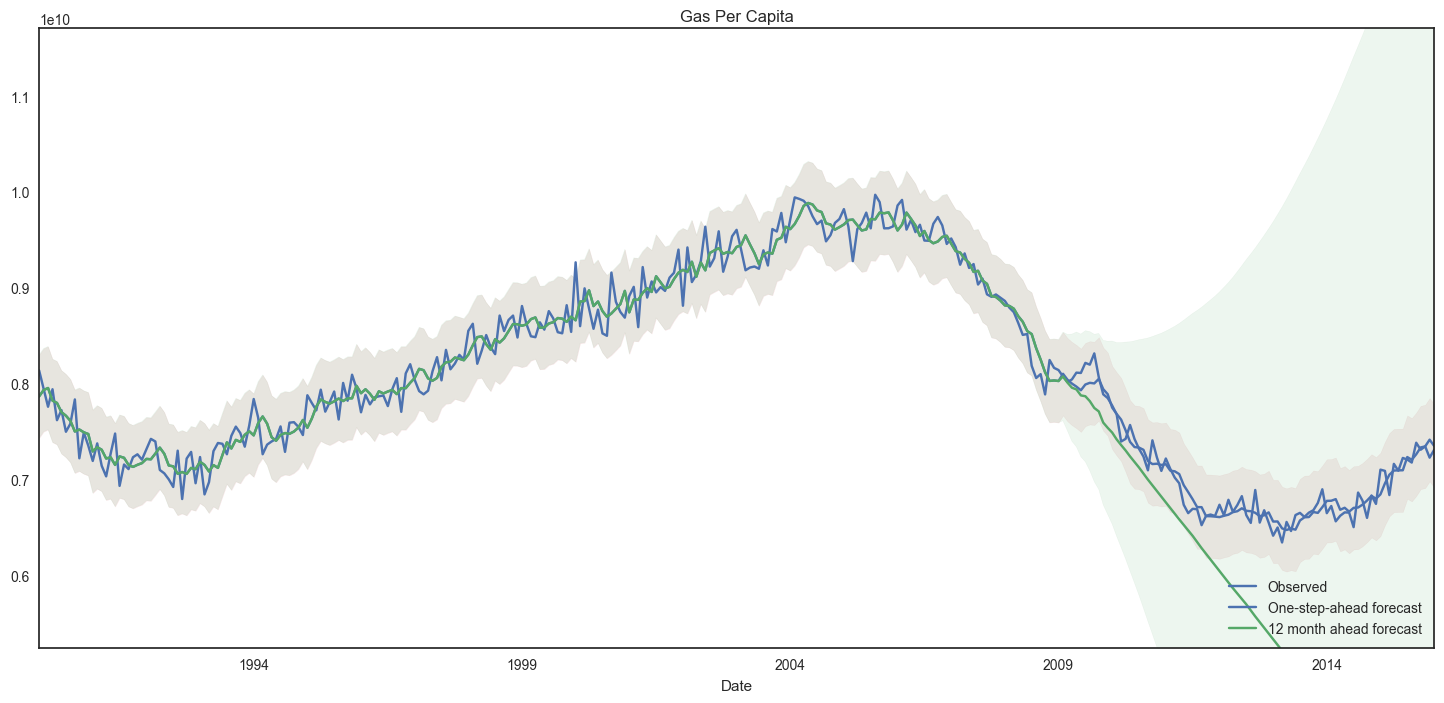

In [27]:
sarimax_mod = sm.tsa.statespace.SARIMAX(endog_trend, exog=exog, freq='M', trend='t', 
                                        order=(1,1,0), seasonal_order=(2,1,1,12),
                                        enforce_stationarity=False, enforce_invertibility=False)
sarimax_res = sarimax_mod.filter(trend_sarimax_fit.params)

sarimax_sa_errors_mod = sm.tsa.statespace.SARIMAX(endog_sa_errors, exog=exog, trend='n',
                                                  order=(3,0,0), seasonal_order=(0,0,1,12))
sarimax_sa_errors_res = sarimax_sa_errors_mod.filter(endog_sa_errors_sarimax_fit.params)

exog_forecast = exog_predict['trend'].ix['2016-01':'2017-12'].values.reshape(24, 1)
# In-sample one-step-ahead predictions
predict = sarimax_res.get_prediction()
predict_sa_errors = sarimax_sa_errors_res.get_prediction()
predict_ci = predict.conf_int()
predict_sa_errors_ci = predict_sa_errors.conf_int()
predict_ci += predict_sa_errors_ci
# Dynamic predictions
predict_dy = sarimax_res.get_prediction(dynamic='2009-01-31')
predict_dy_ci = predict_dy.conf_int()
predict_dy_sa_errors = sarimax_sa_errors_res.get_prediction(dynamic='2009-01-31')
predict_dy_sa_errors_ci = predict_dy_sa_errors.conf_int()
predict_dy_ci = predict_dy_ci + predict_dy_sa_errors_ci

forecast = sarimax_res.forecast(steps=24, exog=exog_forecast)
forecast_sa_errors = sarimax_sa_errors_res.forecast(steps=24, exog=exog_forecast)
# Now let's create the forecast series plot...
forecast_trend = forecast_sa_errors + forecast
fig, ax = plt.subplots(figsize=(18,8))
npre = 4
ax.set(title='Gas Per Capita', xlabel='Date')

# Plot data points
endogenous_observations = endog_trend.ix[year_for_plotting:] + endog_sa_errors.ix[year_for_plotting:]
endogenous_observations.plot(ax=ax, label='Observed')

# Plot predictions
prediction_trend_mean = predict.predicted_mean.ix[year_for_plotting:] + predict_sa_errors.predicted_mean.ix[year_for_plotting:]
prediction_trend_dy_mean = predict_dy.predicted_mean.ix[year_for_plotting:] + predict_dy_sa_errors.predicted_mean.ix[year_for_plotting:]
prediction_trend_mean.plot(ax=ax, style='b', label='One-step-ahead forecast')

ci = predict_ci.ix[year_for_plotting:]
ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], color='r', alpha=0.1)
prediction_trend_dy_mean.plot(ax=ax, style='g', label='12 month ahead forecast')
ci = predict_dy_ci.ix[year_for_plotting:]
ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')
plt.ylim([0.8*min(endog_trend.ix[year_for_plotting:]), 1.2*max(endog_trend.ix[year_for_plotting:])])

(-5057581477.7815161, 3935467864.9717503)

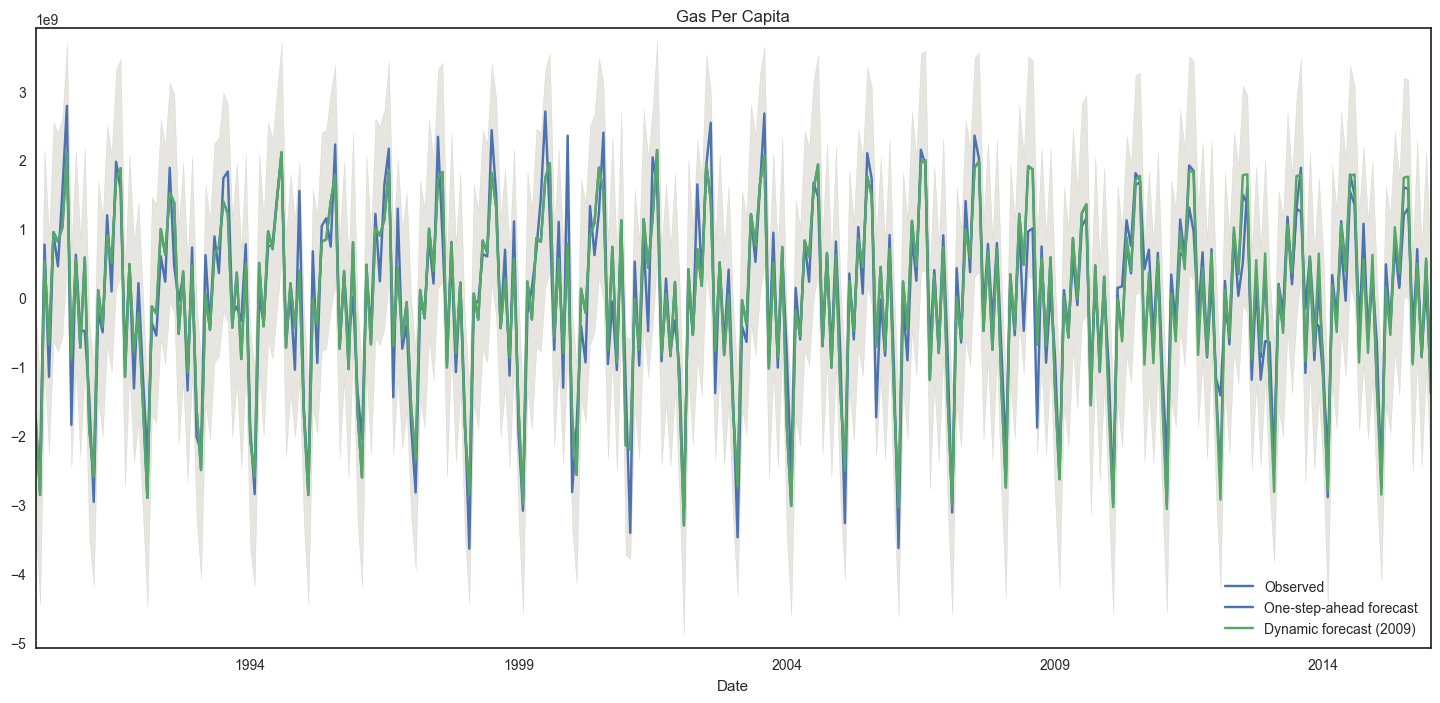

In [29]:
sarimax_cycles_mod = sm.tsa.statespace.SARIMAX(endog_cycle, exog=exog, freq='M', trend='n', 
                                        seasonal_order=(2,1,1,12),
                                        enforce_stationarity=False, enforce_invertibility=False)
sarimax_cycles_res = sarimax_cycles_mod.filter(cycle_sarimax_fit.params)


exog_cycles_forecast = exog_predict['cycles'].ix['2016-01':'2017-12'].values.reshape(24, 1)
# In-sample one-step-ahead predictions
predict_cycles = sarimax_cycles_res.get_prediction()
predict_cycles_ci = predict_cycles.conf_int()
# Dynamic predictions
predict_cycles_dy = sarimax_cycles_res.get_prediction(dynamic='2009-01-31')
predict_cycles_dy_ci = predict_cycles.conf_int()

forecast_cycles = sarimax_cycles_res.forecast(steps=24, exog=exog_forecast)
# Now let's create the forecast series plot...

fig, ax = plt.subplots(figsize=(18,8))
npre = 4
ax.set(title='Gas Per Capita', xlabel='Date')

# Plot data points
endogenous_observations_cycles = endog_cycle.ix[year_for_plotting:]
endogenous_observations_cycles.plot(ax=ax, label='Observed')

# Plot predictions
prediction_cycles_mean = predict_cycles.predicted_mean.ix[year_for_plotting:]
prediction_cycles_dy_mean = predict_cycles_dy.predicted_mean.ix[year_for_plotting:]
prediction_cycles_mean.plot(ax=ax, style='b', label='One-step-ahead forecast')

ci = predict_cycles_ci.ix[year_for_plotting:]
ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], color='r', alpha=0.1)
prediction_cycles_dy_mean.plot(ax=ax, style='g', label='Dynamic forecast (2009)')
ci = predict_cycles_dy_ci.ix[year_for_plotting:]
ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')
plt.ylim([1.4*min(endogenous_observations_cycles), 1.4*max(endogenous_observations_cycles)])
# Because it's negative have to multiply the lower number by 1.4 also.

(3325519301.0995579, 14341048558.192797)

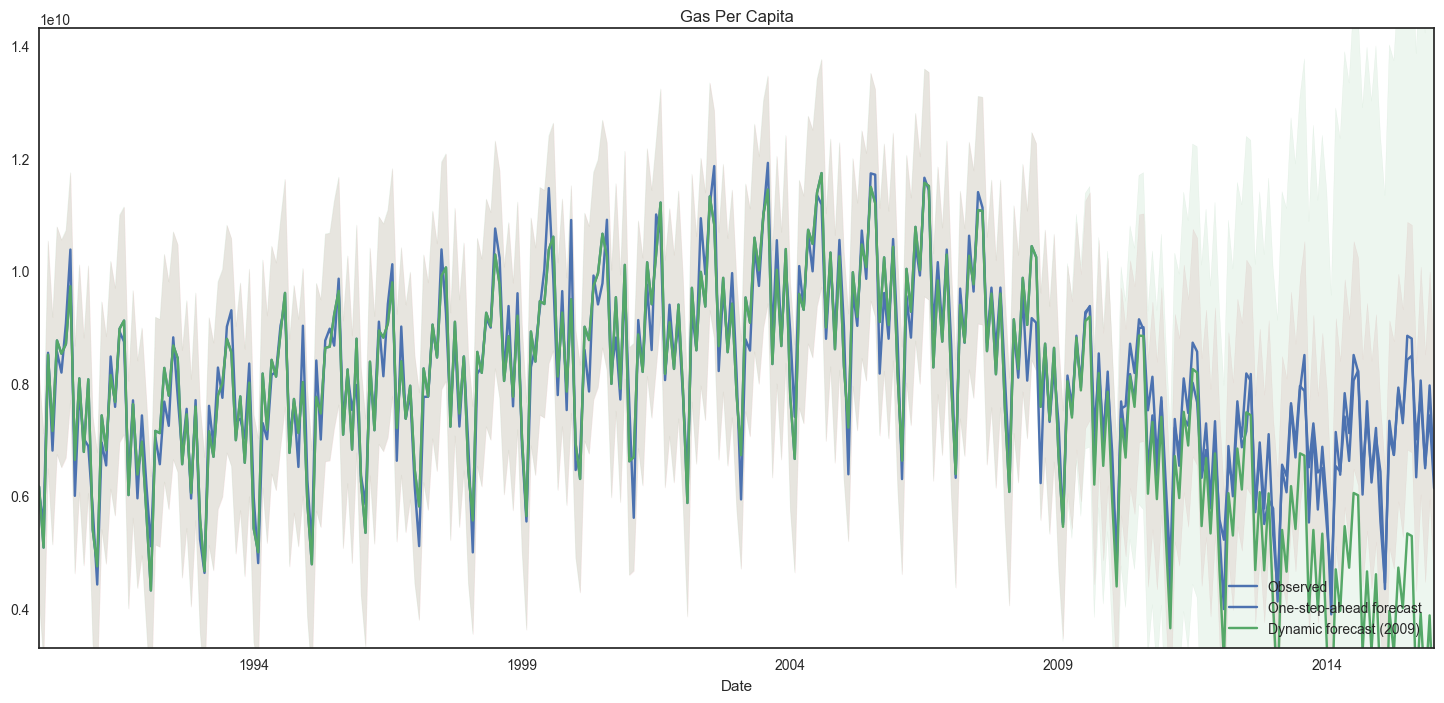

In [30]:
##
## Everything put together
##


fig, ax = plt.subplots(figsize=(18,8))
npre = 4
ax.set(title='Gas Per Capita', xlabel='Date')

# Plot data points
endogenous_observations = endog_trend.ix[year_for_plotting:] + endog_sa_errors.ix[year_for_plotting:] + endogenous_observations_cycles
endogenous_observations.plot(ax=ax, label='Observed')

# Plot predictions
prediction_mean = prediction_trend_mean + prediction_cycles_mean
prediction_dy_mean = prediction_trend_dy_mean + prediction_cycles_dy_mean
prediction_mean.plot(ax=ax, style='b', label='One-step-ahead forecast')

ci = predict_ci.ix[year_for_plotting:] + predict_cycles_ci.ix[year_for_plotting:]
ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], color='r', alpha=0.1)
prediction_dy_mean.plot(ax=ax, style='g', label='Dynamic forecast (2009)')
ci = predict_dy_ci.ix[year_for_plotting:] + predict_cycles_dy_ci.ix[year_for_plotting:]
ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')
plt.ylim([0.8*min(endogenous_observations.ix[year_for_plotting:]), 1.2*max(endogenous_observations.ix[year_for_plotting:])])

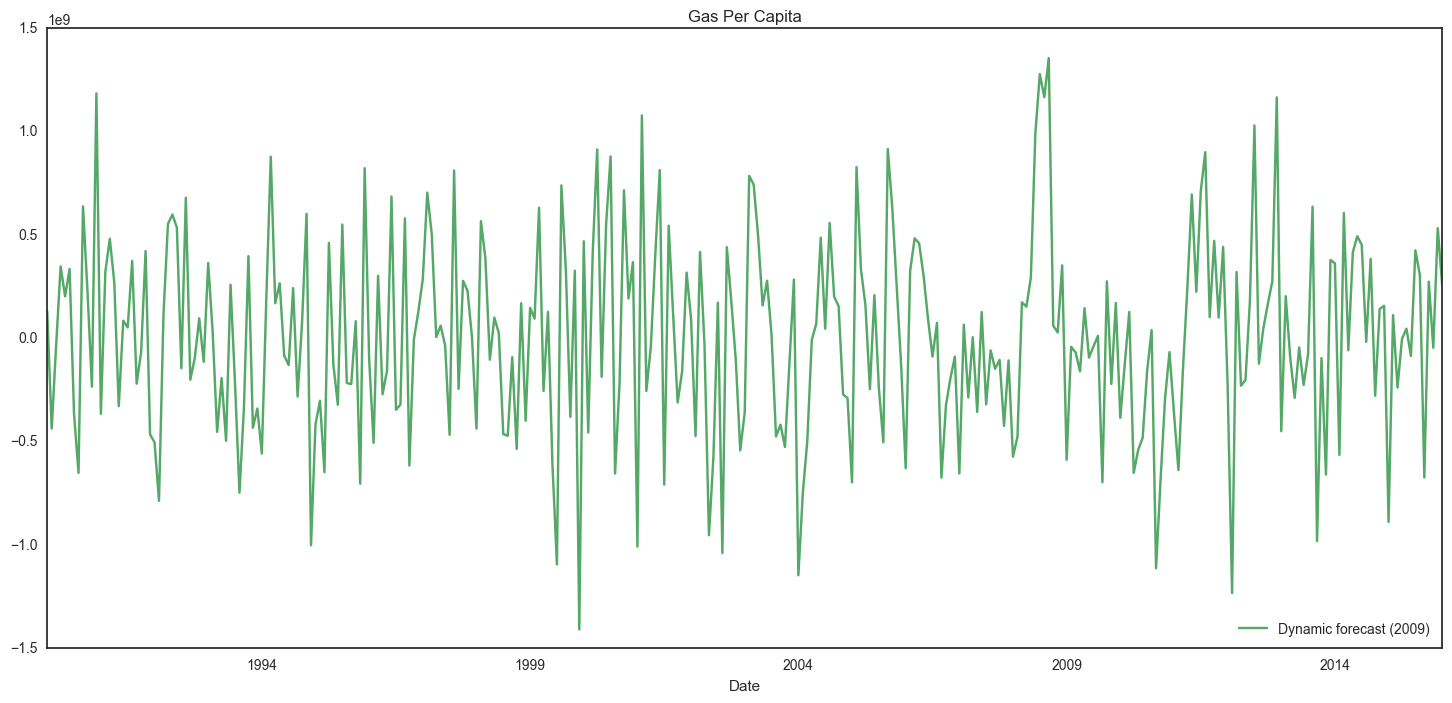

In [31]:
##
## Errors - All of them.
##


fig, ax = plt.subplots(figsize=(18,8))
npre = 4
ax.set(title='Gas Per Capita', xlabel='Date')

# Plot data points
endogenous_observations = endog_trend.ix[year_for_plotting:] + endog_sa_errors.ix[year_for_plotting:] + endogenous_observations_cycles

errors = (prediction_mean - endogenous_observations)
errors.plot(ax=ax, style='g', label='Dynamic forecast (2009)')
legend = ax.legend(loc='lower right')

(198.99440000000001, 452.3064)

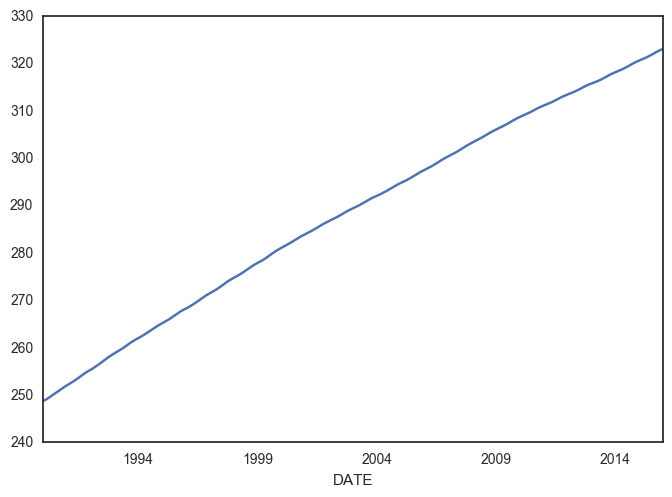

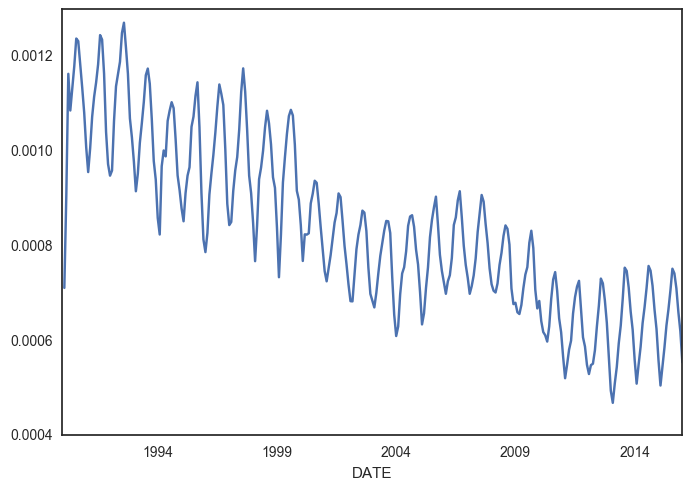

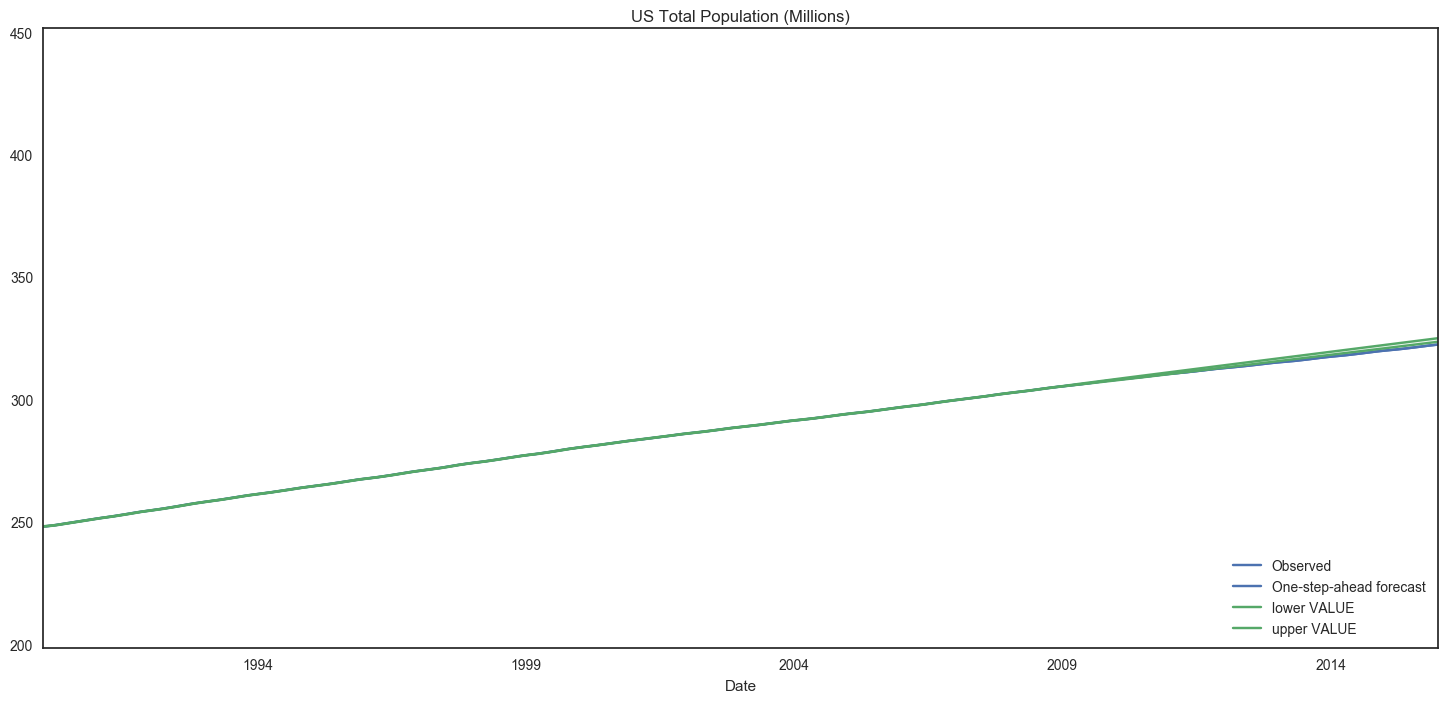

In [33]:
# To finish the forecast need to forecast US population.

first_prediction_year = year_for_plotting
us_population.ix[first_prediction_year:].plot()
# Super straight-up. Basically a line.
plt.figure()
np.log(us_population).ix[first_prediction_year:].diff().plot()


endog_population_forecast = us_population.ix[gas_per_capita.index]
us_population_sarimax = sm.tsa.statespace.SARIMAX(endog_population_forecast, trend='c',
                                                  order=(1,0,0), seasonal_order=(0,0,1,12),
                                                  enforce_stationarity=False,
                                                  enforce_invertibility=False)
us_population_sarimax_fit = us_population_sarimax.fit()
us_population_sarimax_fit.summary()
us_population_sarimax_mod = sm.tsa.statespace.SARIMAX(endog_population_forecast, trend='c',
                                                  order=(1,0,0), seasonal_order=(0,0,1,12),
                                                  enforce_stationarity=False,
                                                  enforce_invertibility=False)
us_population_sarimax_res = us_population_sarimax_mod.filter(us_population_sarimax_fit.params)


predict_us_population = us_population_sarimax_res.get_prediction()
predict_us_population_ci = predict_us_population.conf_int()
# Dynamic predictions
predict_us_population_dy = us_population_sarimax_res.get_prediction(dynamic='2009-01-31')
predict_us_population_dy_ci = predict_us_population_dy.conf_int()

forecast_us_population = us_population_sarimax_res.forecast(steps=24)
# Now let's create the forecast series plot...

fig, ax = plt.subplots(figsize=(18,8))
npre = 4
ax.set(title='US Total Population (Millions)', xlabel='Date')

# Plot data points
endog_population_forecast.ix[first_prediction_year:].plot(ax=ax, label='Observed')

# Plot predictions
prediction_us_population_mean = predict_us_population.predicted_mean
prediction_us_population_dy_mean = predict_us_population_dy.predicted_mean
prediction_us_population_mean.ix[first_prediction_year:].plot(ax=ax, style='b', label='One-step-ahead forecast')

ci = predict_us_population_ci.ix[first_prediction_year:]
ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], color='r', alpha=0.1)

predict_us_population_dy_ci.ix[first_prediction_year:].plot(ax=ax, style='g', label='Dynamic forecast (2009)')

ci = predict_us_population_dy_ci.ix[first_prediction_year:]
ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')
plt.ylim([0.8*min(endog_population_forecast.ix[first_prediction_year:]), 1.4*max(endog_population_forecast.ix[first_prediction_year:])])

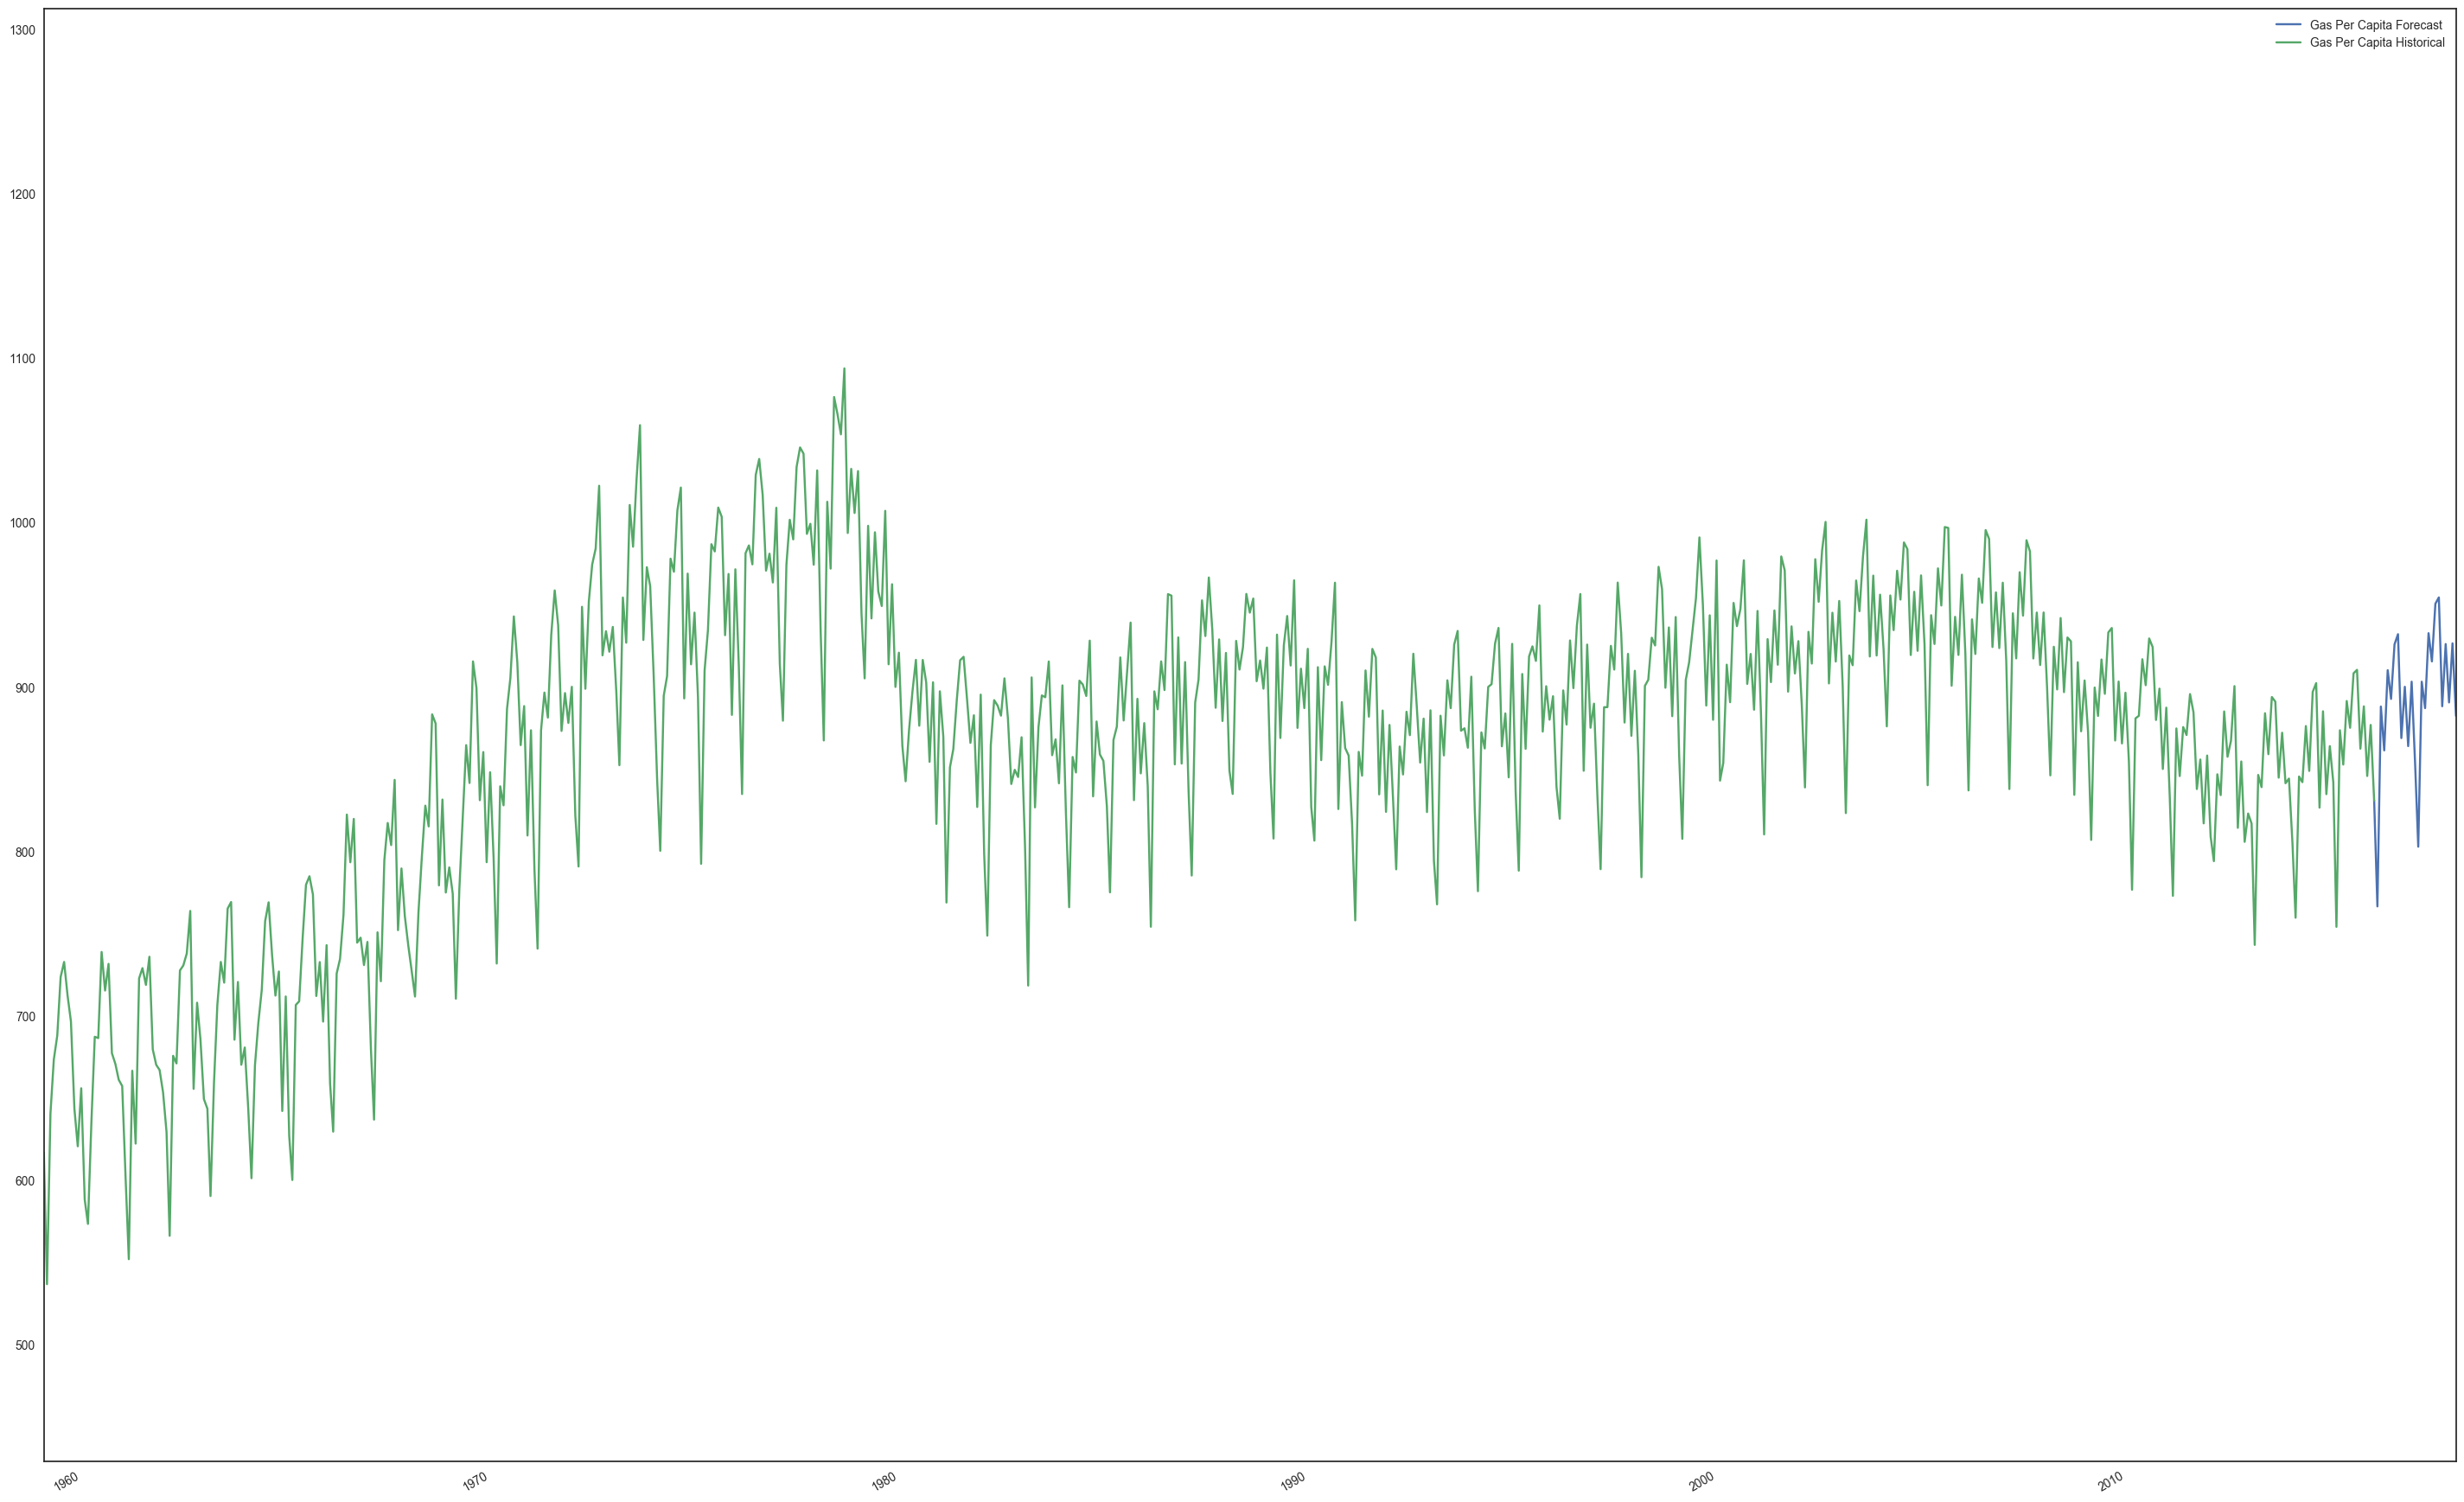

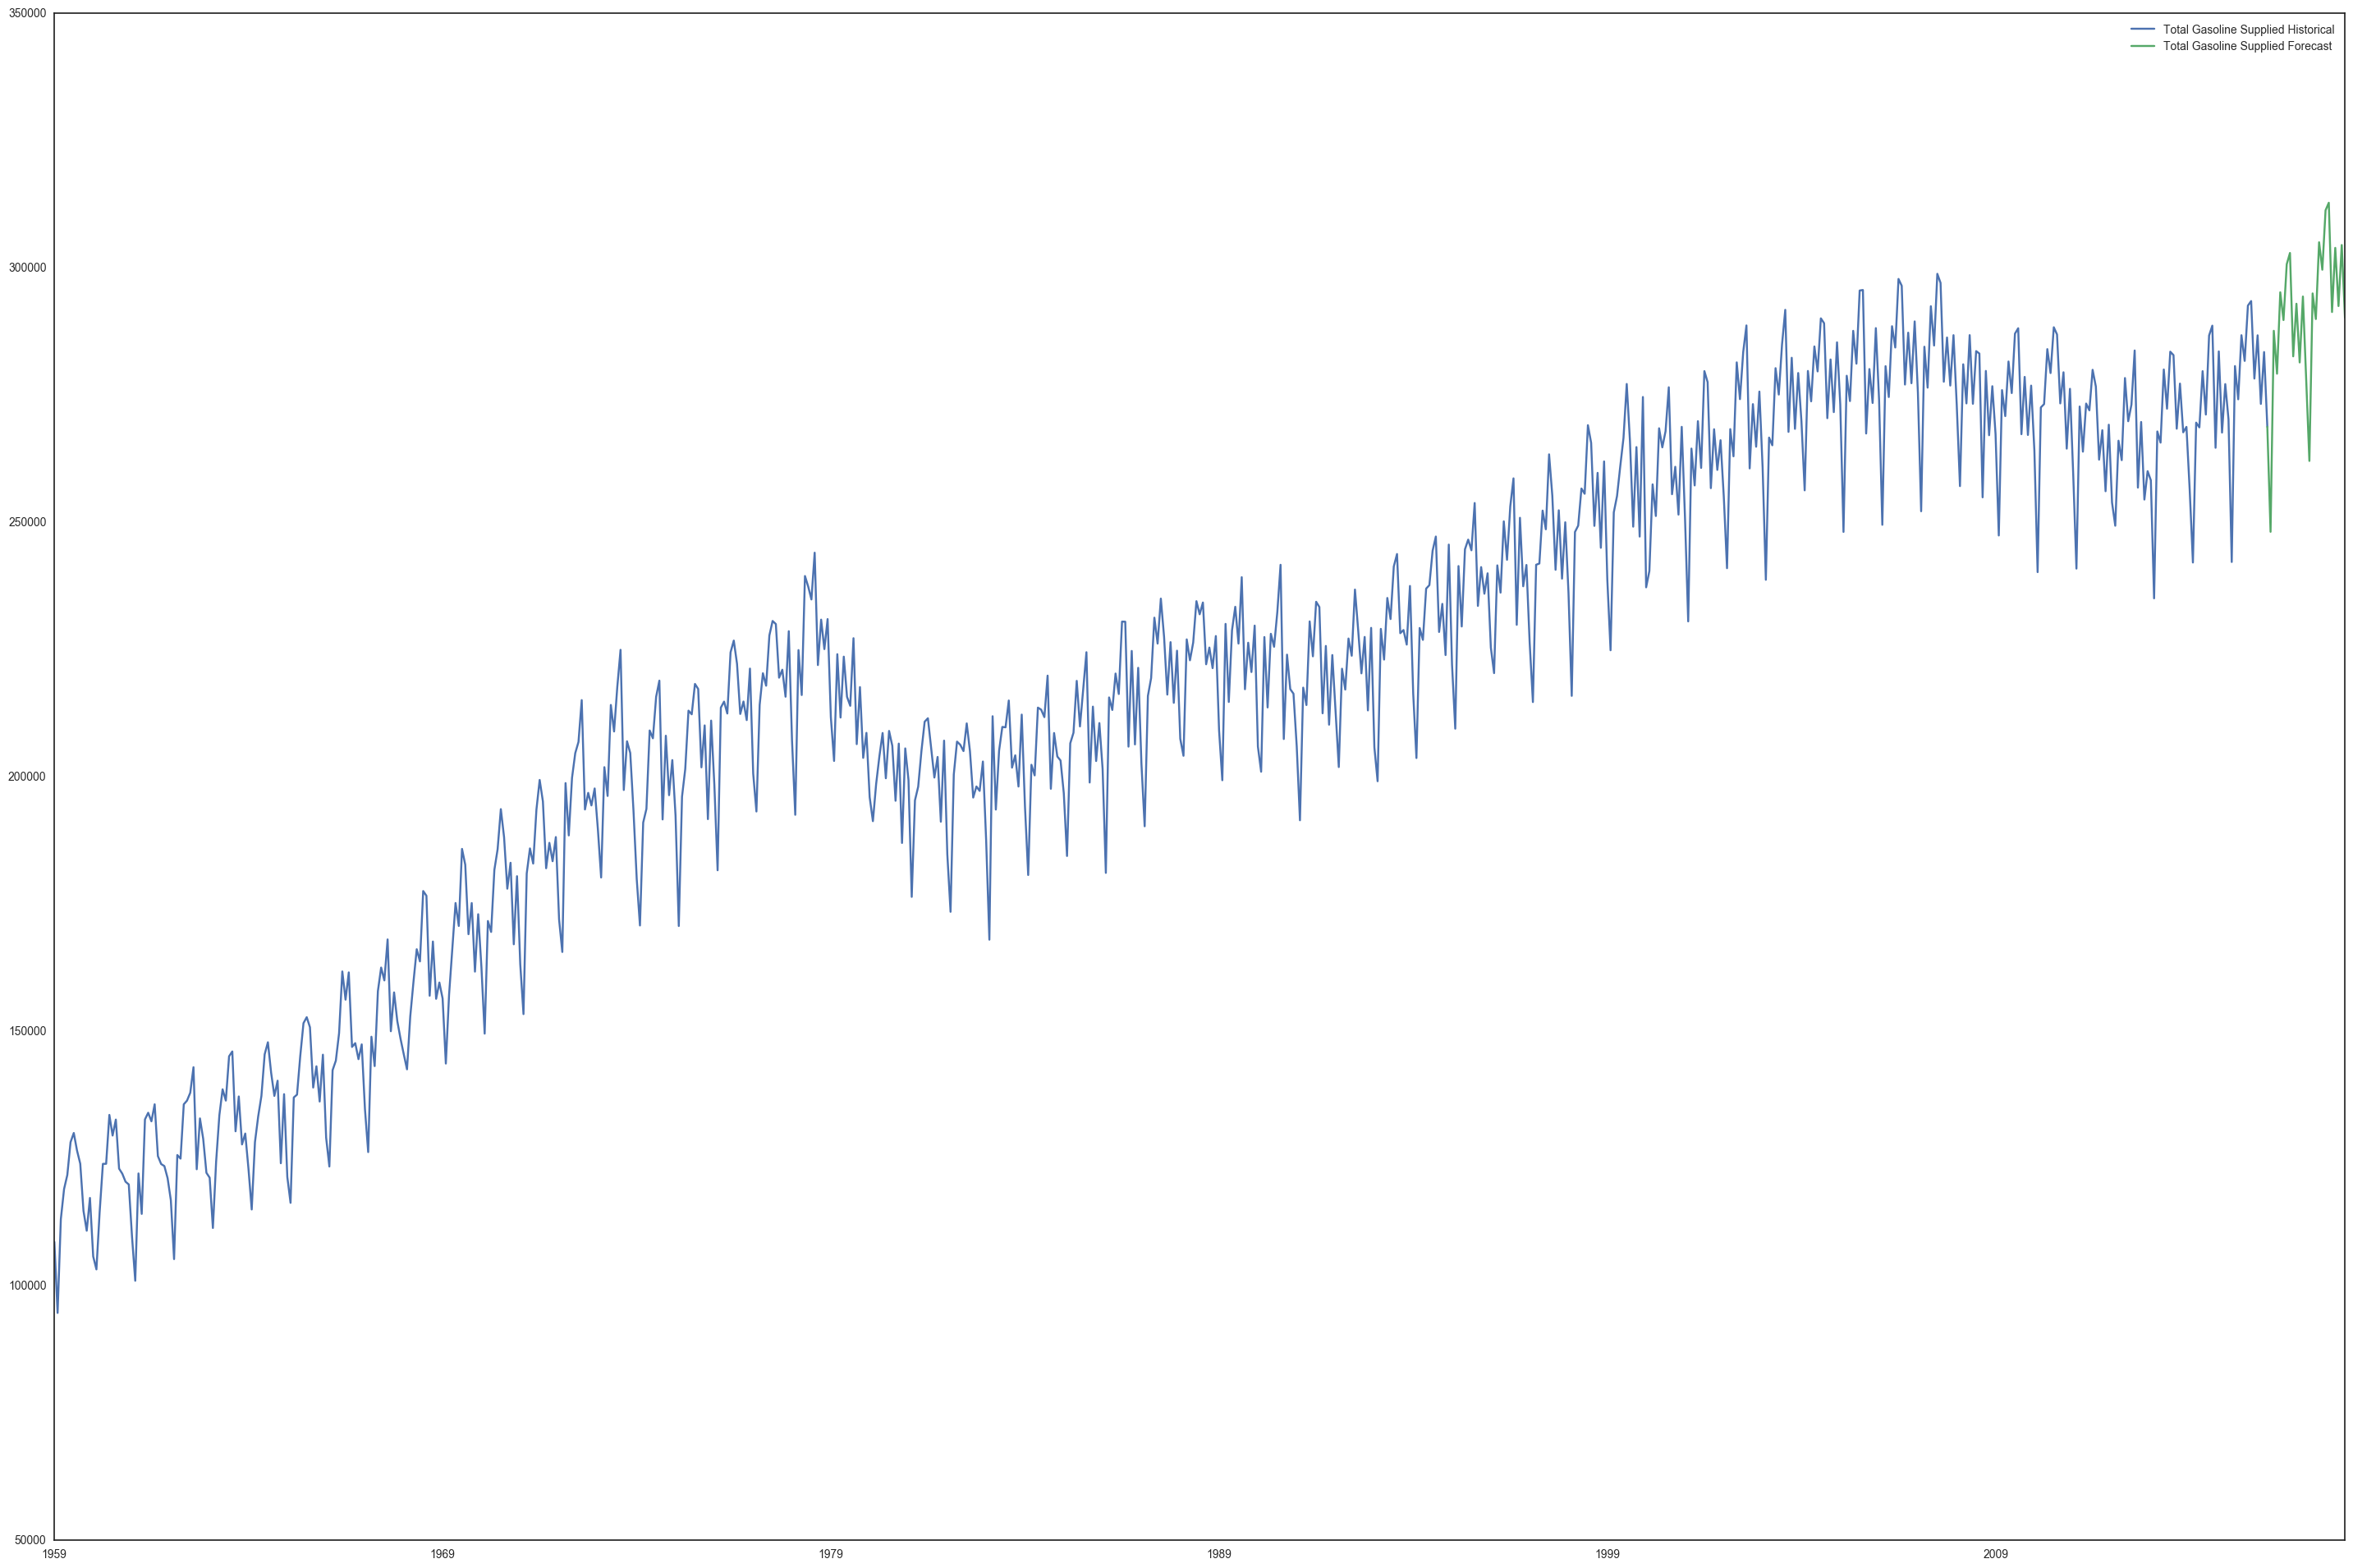

In [34]:
# Now let's plot the actual with the predictions
# And right scales.
# Then do it without being per capita.
def boxcox_reversal(series, lambda_):
    return np.power((series * lambda_) + 1.0, 1.0 / lambda_) - 1.0

fig, ax = plt.subplots(figsize=(36, 24))

forecast_final = forecast_trend + forecast_cycles
forecast_final = boxcox_reversal(forecast_final, lambda_boxcox_reference)
# I'm not quite sure how to calculate standard errors now... since cycles are below zero as well...
# Just do % wise from pre-boxcox


# Original series: gas_per_capita
forecast_final[gas_per_capita.index[-1]] = gas_per_capita.ix[-1]
forecast_final.plot(label='Gas Per Capita Forecast')
gas_per_capita.plot(label='Gas Per Capita Historical')

plt.legend()
plt.ylim([0.8*min(gas_per_capita), 1.2*max(gas_per_capita)])
# us_population

fig, ax = plt.subplots(figsize=(36, 24))

forecast_final = forecast_trend + forecast_cycles
forecast_final = boxcox_reversal(forecast_final, lambda_boxcox_reference)
forecast_final = forecast_final.reindex(sorted(forecast_final.index))
forecast_final = forecast_final * forecast_us_population
total_us_gas_historical = gas_per_capita * us_population
forecast_final[total_us_gas_historical.index[-1]] = total_us_gas_historical.ix[-1]
forecast_final = forecast_final.reindex(sorted(forecast_final.index))
total_us_gas_historical.plot(label='Total Gasoline Supplied Historical')
forecast_final.plot(label='Total Gasoline Supplied Forecast')
plt.legend()

In [38]:
forecast_final.to_csv('gasoline_total_demand_forecast.csv')

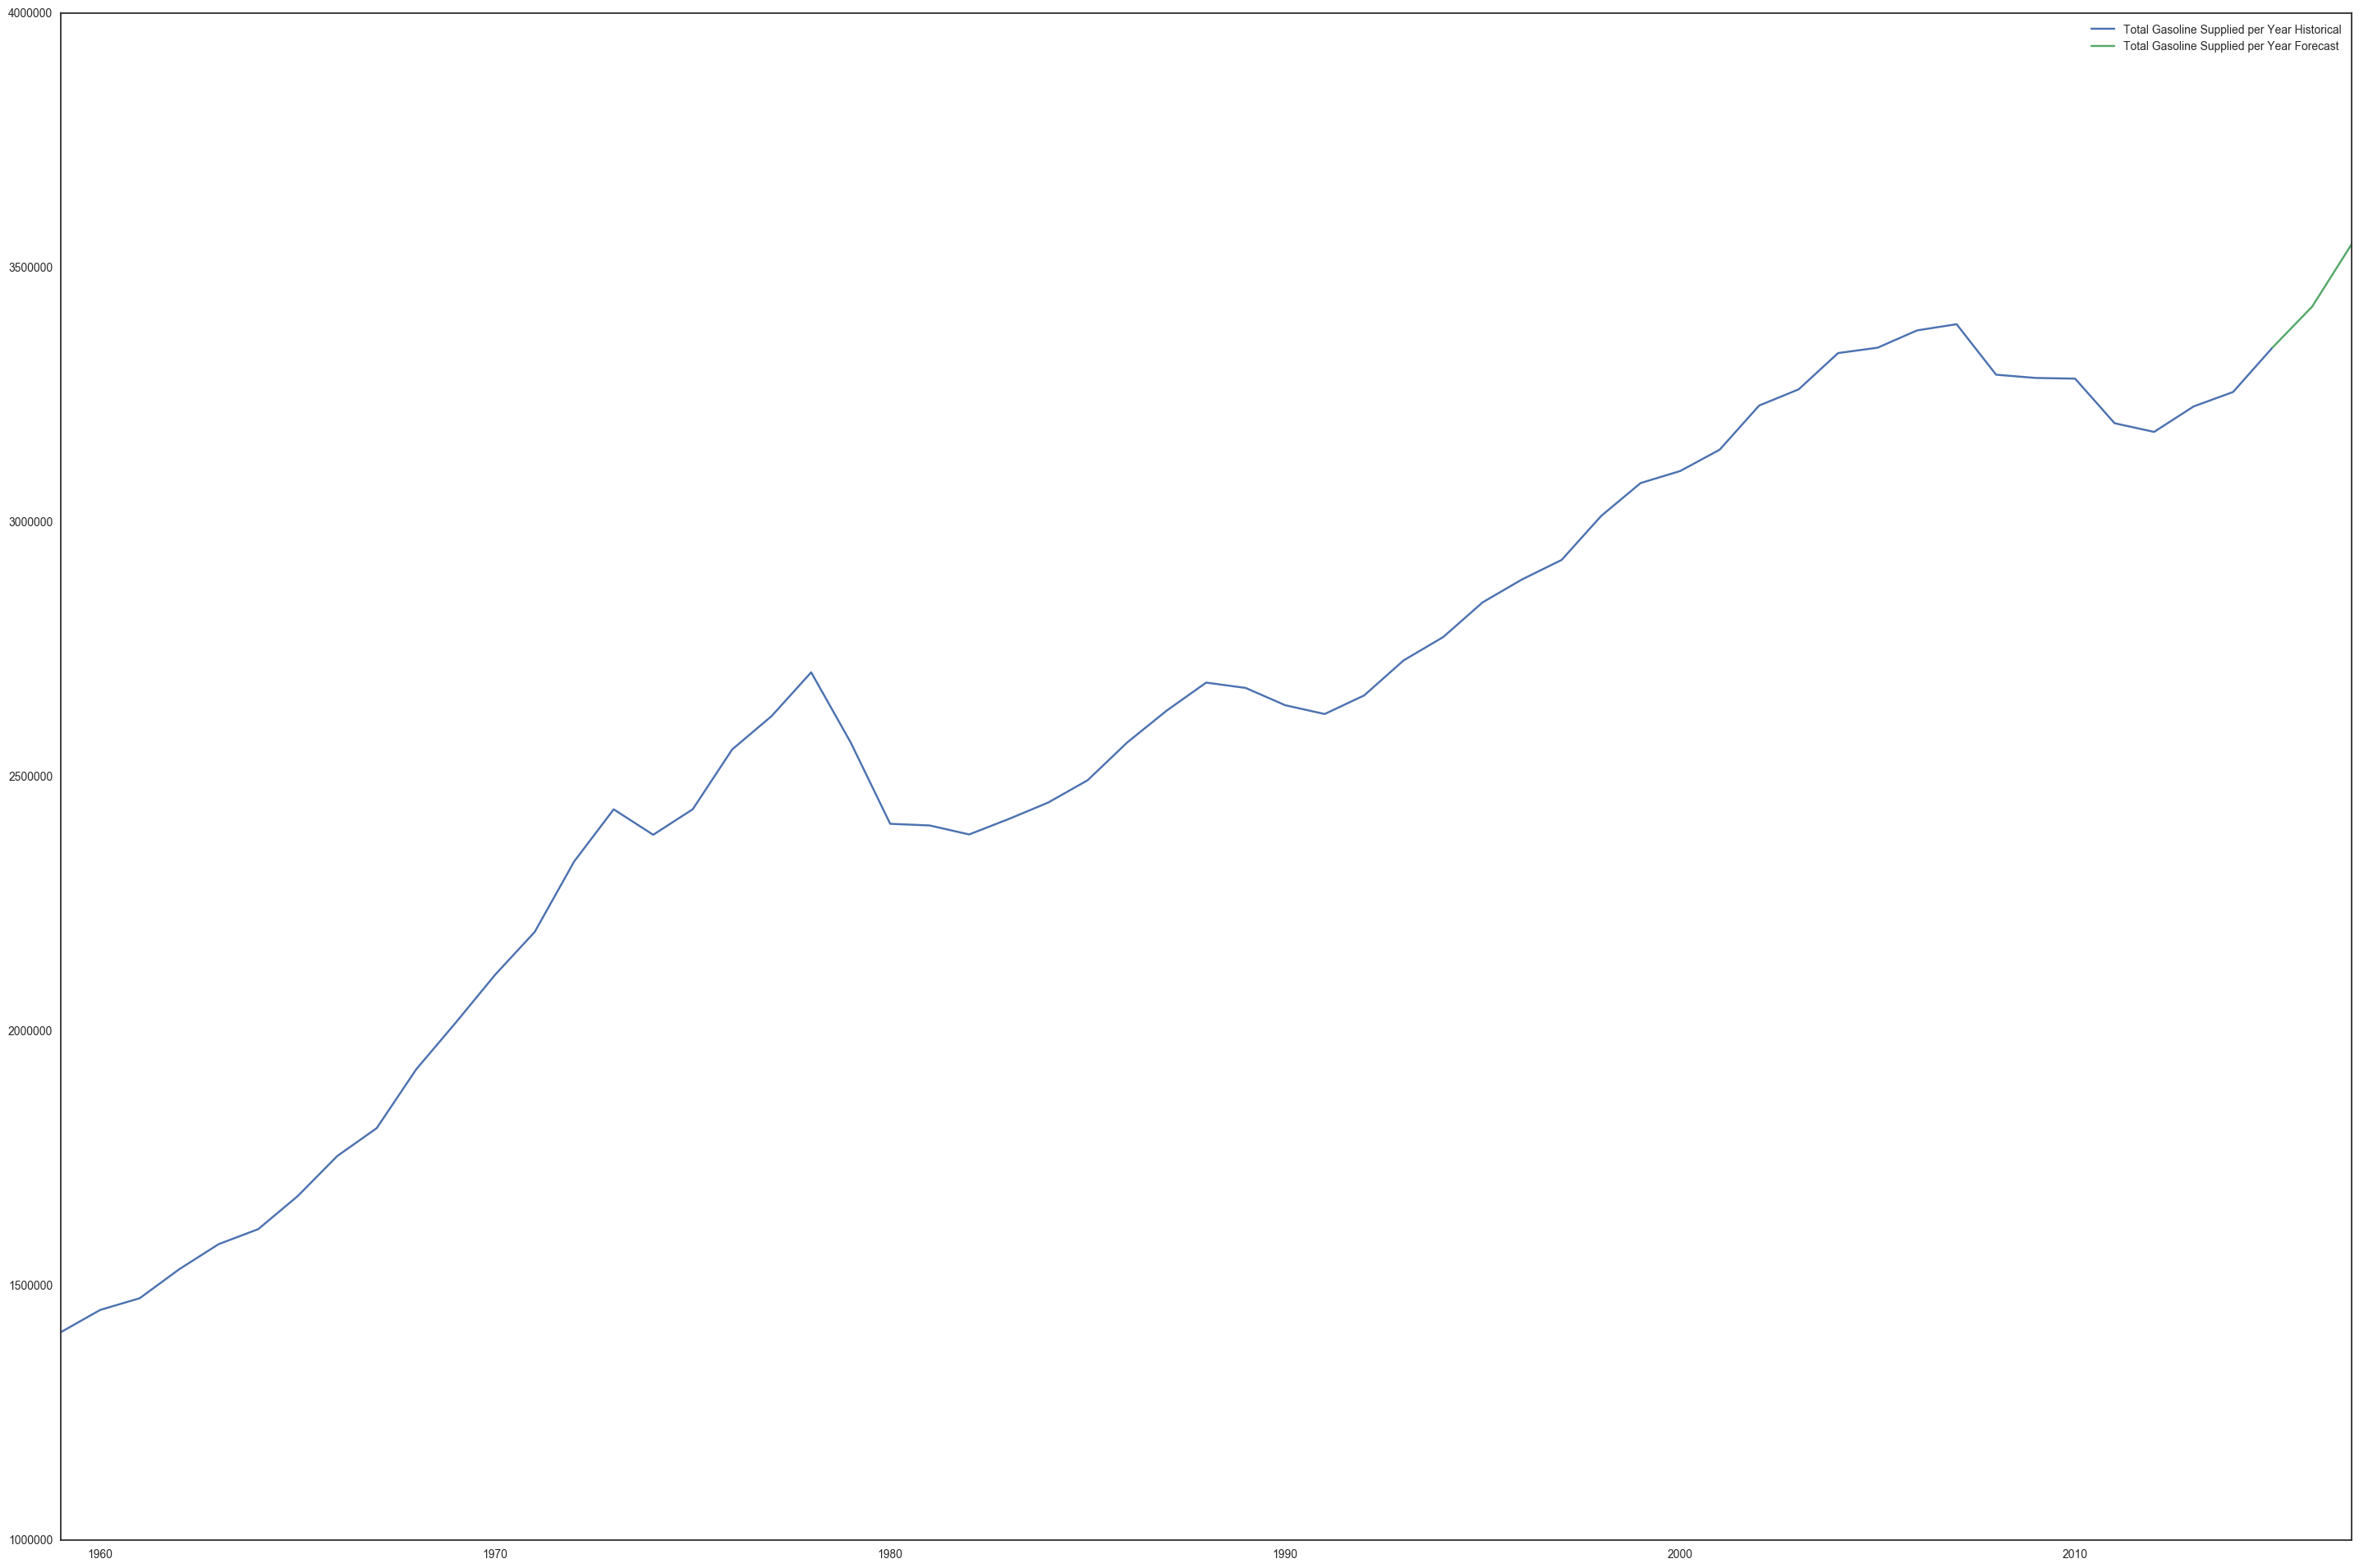

In [35]:
from datetime import date
# Now let's figure out total gasoline forecast / year.
total_gasoline_yearly = total_us_gas_historical.copy().asfreq('M')
total_gasoline_yearly.index = pd.to_datetime(total_gasoline_yearly.index)
total_gasoline_yearly = total_gasoline_yearly.resample("A").sum()
total_gasoline_yearly = total_gasoline_yearly.reindex(total_gasoline_yearly.index[:-1])

total_gasoline_forecast = forecast_final.copy().asfreq('M')
total_gasoline_forecast.index = pd.to_datetime(total_gasoline_forecast.index)
total_gasoline_forecast = total_gasoline_forecast.resample("A").sum()
total_gasoline_forecast = total_gasoline_forecast.reindex(total_gasoline_forecast.index[:-1])
total_gasoline_forecast[total_gasoline_yearly.index[-1]] = total_gasoline_yearly[total_gasoline_yearly.index[-1]]
total_gasoline_forecast = total_gasoline_forecast.reindex(sorted(total_gasoline_forecast.index))
fig, ax = plt.subplots(figsize=(36, 24))
total_gasoline_yearly.plot(label='Total Gasoline Supplied per Year Historical')
total_gasoline_forecast.plot(label='Total Gasoline Supplied per Year Forecast')
plt.legend()

In [36]:
# Numbers not matching... wtf?
print(total_gasoline_forecast)
# Actually it is right, but mine is total per year and Quandl's is average per year.

2015-12-31    3.343615e+06
2016-12-31    3.423676e+06
2017-12-31    3.546241e+06
dtype: float64


In [40]:
import pcia_analysis
print(pcia_analysis.DATASET_INFO['motor_gasoline_supplied'])

{'resample_information': {'frequency': 'M', 'expected_sign': '+', 'column_name': 'Value'}, 'units': 'Thousands of barrels', 'seasonally_adjusted': False, 'objective': 'exogenous', 'internal_name': 'motor_gasoline_supplied', 'dataset_name': 'U.S. Product Supplied of Finished Motor Gasoline, Monthly', 'quandl_database': 'EIA/PET_MGFUPUS1_M', 'source': 'http://api.eia.gov/series/data?api_key=EE01025CF155E957411F0BE8170D7637&series_id=PET.MGFUPUS1.M&out=xml'}


In [43]:
import quandl
latest_gas_data = quandl.get('EIA/PET_MGFUPUS1_M')
latest_gas_data.to_csv('gas_data_latest.csv')